# Step - 2

## Preconditions

### Install the required libraries
```bash
pip install -r requirements.txt
```



In [9]:
# Importing the required libraries
import trimesh
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

## Step 2.1: Analyzing a Single Shape

In [11]:
def analyze_shape(_file_path):
    try:
        mesh = trimesh.load(_file_path)
        num_vertices = len(mesh.vertices)
        num_faces = len(mesh.faces)
        face_types = mesh.faces.shape[1]  # 3 for triangles, 4 for quads
        bounding_box = mesh.bounding_box.extents
        return num_vertices, num_faces, face_types, bounding_box
    except Exception as e:
        print(f"Error processing {_file_path}: {e}")
        return None

## Step 2.2: Statistics Over the Whole Database

In [13]:
# Getting the properties of all the shapes
shape_data = []

# Define the root folder where the search begins
root_folder = './ShapeDatabase_INFOMR-master'

# List to store all .obj file paths
obj_file_paths = []

# Walk through the folder structure
for dirpath, dirnames, filenames in os.walk(root_folder):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = os.path.join(dirpath, file)
            obj_file_paths.append(full_path)

# Print all .obj file paths                                                                                  
for path in obj_file_paths:
    file_path = path.replace('\\', '/')
    genre = file_path.split('/')[-2]
    shape_name = file_path.split('/')[-1].split('.')[0]
    shape_properties = analyze_shape(file_path)
    shape_data.append({
        'file_path': file_path,
        'genre': genre,
        'shape_name': shape_name,
        'num_vertices': shape_properties[0],
        'num_faces': shape_properties[1],
        'face_types': shape_properties[2],
        'bounding_box': shape_properties[3].tolist()
    })

In [16]:
# remove the outliers from the shape_data where num_vertices <= 100 or num_faces <= 100
shape_data_filtered = [data for data in shape_data if data['num_vertices'] > 100 and data['num_faces'] > 100]
print(f"Number of outliers: {len(shape_data) - len(shape_data_filtered)}")

Number of outliers: 95


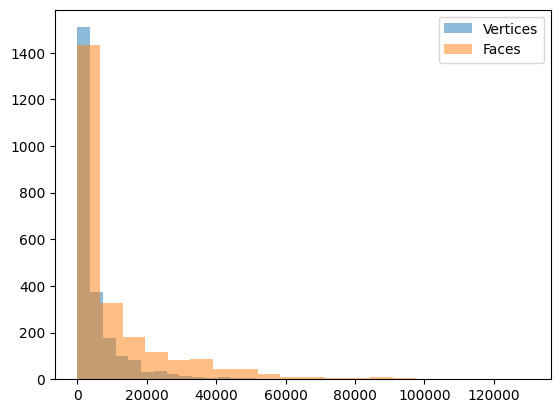

In [18]:
# Data preparation
vertices = [data['num_vertices'] for data in shape_data_filtered]
faces = [data['num_faces'] for data in shape_data_filtered]

# Histogram plot
plt.hist(vertices, bins=20, alpha=0.5, label='Vertices')
plt.hist(faces, bins=20, alpha=0.5, label='Faces')
plt.legend(loc='upper right')                                                                                                                                                                                                                                                                                                            
plt.show()

69


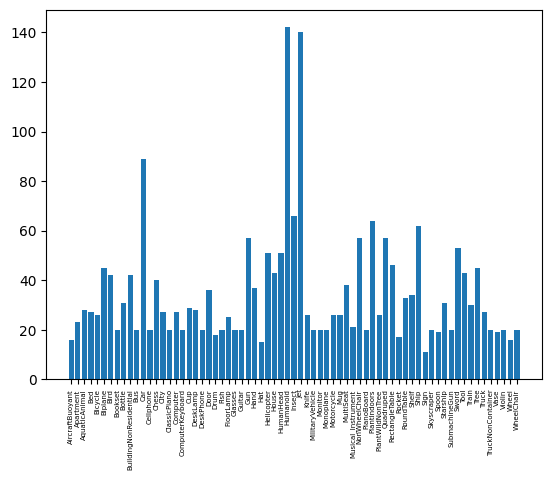

In [20]:
# check the number of each genre in the dataset
# then plot the bar chart
# then x-axis is the genre and y-axis is the number of shapes in that genre
from collections import Counter
genre_count = Counter([data['genre'] for data in shape_data_filtered])
print(len(genre_count))
plt.bar(genre_count.keys(), genre_count.values())
# and the x-axis should be tilted 45 degrees
plt.xticks(rotation=90)
# and the x-axies fonr size should be 5
plt.xticks(fontsize=5)
# make the figure size bigger
plt.show()

In [22]:
# find the median and avrage number of the genre_count
import numpy as np
median = np.median(list(genre_count.values()))
average = np.mean(list(genre_count.values()))
print(f"Median: {median}, Average: {average}")


Median: 27.0, Average: 34.608695652173914


## 2.3 Resampling Data

In [ ]:
# Choose the average number of shapes per genre as the threshold
# for those genres that have fewer shapes than the threshold, we will upsample them
# for those genres that have more shapes than the threshold, we will downsample them
import random
threshold = int(average)
print(f"Threshold: {threshold}")
# UP_SAMPLING_LIMITATION = threshold - 5
# DOWN_SAMPLING_LIMITATION = threshold + 5

# Resampling the data
resampled_data = []
for genre, count in genre_count.items():
    genre_data = [data for data in shape_data_filtered if data['genre'] == genre]
    if count < threshold:
        random.shuffle(genre_data)
        # 当计数小于上采样限制时，进行上采样
        resampled_data.extend(genre_data * (threshold // count))
        resampled_data.extend(genre_data[:threshold % count])
    elif count >= threshold:
        # 当计数大于下采样限制时，进行下采样
        # 随机选择一部分数据
        random.shuffle(genre_data)
        resampled_data.extend(genre_data[:threshold])
    # else:
    #     # 如果在限制范围内，直接使用现有数据
    #     resampled_data.extend(genre_data)


In [ ]:
resmapled_genre_count = Counter([data['genre'] for data in resampled_data])

plt.bar(resmapled_genre_count.keys(), resmapled_genre_count.values())
# and the x-axis should be tilted 45 degrees
plt.xticks(rotation=90)
# and the x-axies fonr size should be 5
plt.xticks(fontsize=5)
# make the figure size bigger
plt.show()

In [ ]:
resmapled_genre_count

In [ ]:
# Save the shape data to a file
# import json
# with open('shape_data.json', 'w') as f:
#     json.dump(resampled_data, f)

In [ ]:
# Load the shape data from the file
# import json
# with open('shape_data.json', 'r') as f:
#     resampled_data = json.load(f)

## Step 2.4: Normalizing shapes

In [ ]:
def normalize_shape(_mesh):
    centroid = mesh.centroid
    mesh.vertices -= centroid  # 平移到原点
    max_extent = mesh.bounding_box.extents.max()  # 获取最大边长
    if max_extent > 0:
        mesh.vertices /= max_extent  # 统一缩放
    return mesh

In [ ]:
# save all the normalized shapes to a folder

# 1.create the genre folders
genre_names = list(resmapled_genre_count.keys())
for genre in genre_names:
    os.makedirs(f'./normalized_database/{genre}', exist_ok=False)
    
# 2.save the normalized shapes to the genre folders
for data in resampled_data:
    mesh = trimesh.load(data['file_path'])
    normalized_mesh = normalize_shape(mesh)
    normalized_mesh.export(f"./normalized_database/{data['genre']}/{data['shape_name']}.obj")
    
# 3.save the shape data to a file
# Getting the properties of all the shapes
normalized_shape_data = []

# Define the root folder where the search begins
normalized_shape_folder = './normalized_database'

# List to store all .obj file paths
normalized_obj_file_paths = []

# Walk through the folder structure
for dirpath, dirnames, filenames in os.walk(normalized_shape_folder):
    for file in filenames:
        if file.endswith('.obj'):
            # Get the full file path and add it to the list
            full_path = os.path.join(dirpath, file)
            normalized_obj_file_paths.append(full_path)

# Print all .obj file paths                                                                                  
for path in normalized_obj_file_paths:
    file_path = path.replace('\\', '/')
    genre = file_path.split('/')[-2]
    shape_name = file_path.split('/')[-1].split('.')[0]
    shape_properties = analyze_shape(file_path)
    normalized_shape_data.append({
        'file_path': file_path,
        'genre': genre,
        'shape_name': shape_name,
        'num_vertices': shape_properties[0],
        'num_faces': shape_properties[1],
        'face_types': shape_properties[2],
        'bounding_box': shape_properties[3].tolist(),
        'centroid': trimesh.load(file_path).centroid.tolist(),
    })

with open('normalized_shape_data.json', 'w') as f:
    json.dump(normalized_shape_data, f)


In [ ]:
# check if the normalization works
# condition 1: the centroid of the shape should be (0, 0, 0)
# condition 2: the max extent of the shape should be 1
import numpy as np

# 定义容差值
EPSILON = 0.5  # 根据需要调整

# 假设 normalized_shape_data 是包含归一化后网格数据的列表
for data in normalized_shape_data:
    centroid = data['centroid']
    file_path = data['file_path']
    
    # 条件 1: 检查重心是否接近 (0, 0, 0)
    if not np.allclose(centroid, [0, 0, 0], atol=EPSILON):
        print(f"Error: {file_path} 的重心 {centroid} 不接近 (0, 0, 0)")
    
    # 加载归一化后的网格
    mesh = trimesh.load(file_path)
    
    # 条件 2: 检查最大边长是否接近 1
    max_extent = mesh.bounding_box.extents.max()
    if not np.isclose(max_extent, 1.0, atol=EPSILON):
        print(f"Error: {file_path} 的最大边长 {max_extent} 不接近 1")

# Step 3.1: Full Normalization

In [35]:
def normalize_shape(mesh):
    # Centering (already implemented in Step 2)
    mesh.vertices -= mesh.center_mass

    # Scaling (already implemented in Step 2)
    scale = np.cbrt(1.0 / mesh.volume)
    mesh.vertices *= scale

    # Alignment using PCA
    pca = PCA(n_components=3)
    pca.fit(mesh.vertices)
    aligned_vertices = pca.transform(mesh.vertices)
    mesh.vertices = aligned_vertices

    # Flipping using Moment Test
    for axis in range(3):
        if np.sum(mesh.vertices[:, axis]) < 0:
            mesh.vertices[:, axis] *= -1

    return mesh

# Step 3.2: Feature Extraction


In [36]:
def extract_features(mesh):
    features = {}

    # Elementary Descriptors
    features['Surface Area'] = mesh.area
    features['Compactness'] = (36 * np.pi * (mesh.volume ** 2)) / (mesh.area ** 3)  # Compactness with respect to a sphere
    obb = mesh.bounding_box_oriented
    features['3D Rectangularity'] = mesh.volume / obb.volume
    features['Diameter'] = np.max(mesh.bounding_box.extents)
    convex_hull = mesh.convex_hull
    features['Convexity'] = mesh.volume / convex_hull.volume
    covariance_matrix = np.cov(mesh.vertices, rowvar=False)
    eigenvalues, _ = np.linalg.eigh(covariance_matrix)
    features['Eccentricity'] = max(eigenvalues) / min(eigenvalues)

    # Property Descriptors (using histograms)
    num_samples = 1000
    bins = 10  # Number of bins for the histogram

    random_points = mesh.vertices[np.random.choice(mesh.vertices.shape[0], num_samples, replace=True)]

    # A3: Angle between 3 random vertices
    angles = []
    for i in range(num_samples):
        v1, v2, v3 = random_points[np.random.choice(num_samples, 3, replace=False)]
        vec1 = v2 - v1
        vec2 = v3 - v1
        cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        angles.append(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
    features['A3'] = np.histogram(angles, bins=bins, range=(0, np.pi))[0]

    # D1: Distance between barycenter and random vertex
    barycenter = mesh.center_mass
    distances = np.linalg.norm(random_points - barycenter, axis=1)
    features['D1'] = np.histogram(distances, bins=bins)[0]

    # D2: Distance between 2 random vertices
    d2_distances = []
    for i in range(num_samples // 2):
        v1, v2 = random_points[np.random.choice(num_samples, 2, replace=False)]
        d2_distances.append(np.linalg.norm(v1 - v2))
    features['D2'] = np.histogram(d2_distances, bins=bins)[0]

    # D3: Square root of area of triangle given by 3 random vertices
    areas = []
    for i in range(num_samples // 3):
        v1, v2, v3 = random_points[np.random.choice(num_samples, 3, replace=False)]
        area = np.linalg.norm(np.cross(v2 - v1, v3 - v1)) / 2
        areas.append(np.sqrt(area))
    features['D3'] = np.histogram(areas, bins=bins)[0]

    # D4: Cube root of volume of tetrahedron formed by 4 random vertices
    volumes = []
    for i in range(num_samples // 4):
        v1, v2, v3, v4 = random_points[np.random.choice(num_samples, 4, replace=False)]
        volume = np.abs(np.dot(v4 - v1, np.cross(v2 - v1, v3 - v1))) / 6
        volumes.append(np.cbrt(volume))
    features['D4'] = np.histogram(volumes, bins=bins)[0]

    return features

In [37]:
# Example Usage
# Using the normalized shape file paths from Step 2
normalized_shape_folder = './normalized_database'
normalized_obj_file_paths = []

# Walk through the folder structure to get all normalized shape paths
for dirpath, dirnames, filenames in os.walk(normalized_shape_folder):
    for file in filenames:
        if file.endswith('.obj'):
            full_path = os.path.join(dirpath, file)
            normalized_obj_file_paths.append(full_path)

all_features = []
for shape_file in normalized_obj_file_paths:
    shape = trimesh.load(shape_file)
    normalized_shape = normalize_shape(shape)
    features = extract_features(normalized_shape)
    features['Shape File'] = shape_file
    all_features.append(features)

# Create a DataFrame for better tabular output
features_df = pd.DataFrame(all_features)
print(features_df)

ValueError: Points must be coplanar